#Image Generation and Background Replacement using Stable Diffusion





### Project Goals

1. **Automate Image Masking**: Use CLIPSeg to automatically generate high-quality masks based on user prompts.
2. **Inpaint Images**: Replace masked areas with new content using Stable Diffusion inpainting, guided by user-provided descriptions.
3. **Enhance Usability**: Make the process user-friendly, with minimal manual intervention, while producing visually appealing results.

---

### What This Notebook Covers

- **Image Downloading**: Load an image either from a URL or a local file path.
- **Mask Generation**: Automatically create a mask for specific parts of the image based on a text prompt using CLIPSeg.
- **Mask Refinement**: Enhance the mask for better results by applying smoothing and edge detection techniques.
- **Inpainting Process**: Use Stable Diffusion to fill the masked area with new content based on a descriptive text prompt.
- **Results Display**: Visualize the inpainted images and save them for later use.

This notebook demonstrates how to automate the masking and inpainting process with minimal user input while ensuring high-quality outputs.

In [ ]:
# Downloading dependencies and tools required
!pip install diffusers transformers accelerate scipy safetensors


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Enhanced mask saved as 'enhanced_mask.png'.


  0%|          | 0/50 [00:00<?, ?it/s]

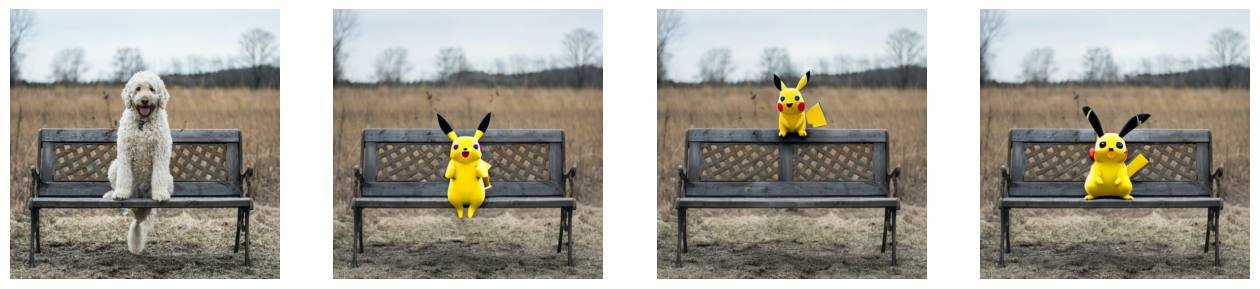

In [2]:
# Imports
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from diffusers import StableDiffusionInpaintPipeline
from io import BytesIO
import numpy as np
import cv2

# Initialize CLIPSeg for masking
clipsegProcessor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipsegModel = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

# Initialize Stable Diffusion Inpainting Pipeline
device = "cuda"
modelPath = "stabilityai/stable-diffusion-2-inpainting"
pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    modelPath,
    torch_dtype=torch.float16,
).to(device)

# Function to download image from URL or local path
def downloadImage(url):
    try:
        if url.startswith('http'):
            response = requests.get(url)
            image = Image.open(BytesIO(response.content)).convert("RGB")
        else:
            image = Image.open(url).convert("RGB")
        return image
    except Exception as e:
        print(f"Error downloading image: {e}")
        return None

# Function to enhance mask quality
def enhanceMask(mask, threshold=None, kernelSize=5, useEdges=True):
    """
    Refines the mask by applying thresholding, morphology, and edge refinement.
    """
    mask = mask.cpu().numpy() if isinstance(mask, torch.Tensor) else np.array(mask)
    threshold = threshold if threshold else mask.mean()
    binaryMask = (mask > threshold).astype(np.uint8) * 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernelSize, kernelSize))
    refinedMask = cv2.morphologyEx(binaryMask, cv2.MORPH_CLOSE, kernel)

    if useEdges:
        edges = cv2.Canny(refinedMask, 100, 200)
        refinedMask = cv2.bitwise_or(refinedMask, edges)

    smoothedMask = cv2.GaussianBlur(refinedMask, (5, 5), 0)
    return Image.fromarray(smoothedMask)

# Function to generate mask using CLIPSeg
def generateMask(image, prompts):
    """
    Creates a segmentation mask based on input image and text prompts.
    """
    inputs = clipsegProcessor(
        text=prompts,
        images=[image] * len(prompts),
        padding="max_length",
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = clipsegModel(**inputs)
    predictions = outputs.logits.unsqueeze(1)
    masks = torch.sigmoid(predictions)
    return enhanceMask(masks[0][0])

# Function for inpainting
def inpaintImage(image, maskImage, inpaintPrompt, guidanceScale=7.5, numSamples=3):
    """
    Inpaints the image using the mask and textual prompt with Stable Diffusion.
    """
    generator = torch.Generator(device="cuda").manual_seed(0)
    images = pipeline(
        prompt=inpaintPrompt,
        image=image,
        mask_image=maskImage,
        guidance_scale=guidanceScale,
        generator=generator,
        num_images_per_prompt=numSamples,
    ).images
    images.insert(0, image)
    return images

# Function to display images
def displayImages(images):
    """
    Displays images side by side.
    """
    fig, axes = plt.subplots(1, len(images), figsize=(16, 8))
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Main execution
imageUrl = '/content/dog.png'

maskPrompt = "dog"  # Object to mask (e.g., "dog" in the image)
inpaintPrompt = "a pikachu sitting on the bench" # Description of what will replace the masked object

# Step 1: Download and resize image
image = downloadImage(imageUrl).resize((512, 512))

# Step 2: Generate mask
maskImage = generateMask(image, [maskPrompt])
maskImage.save("enhanced_mask.png")
print("Enhanced mask saved as 'enhanced_mask.png'.")

# Step 3: Perform inpainting
generatedImages = inpaintImage(image, maskImage, inpaintPrompt)

# Step 4: Display results
displayImages(generatedImages)
